# Testing Categorical NN
Code to test how the calibrated NN works with different dataset

In [ ]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
import scipy
import numpy as np
import pickle
import gzip

### Utils

NN implementation and calibration functions

In [2]:
def myinverse(x,ub,lb):
    res = np.zeros (len(ub))
    for i in range (len(ub)):
        res[i] = x[i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5

    return res

NumLayers=3

def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x

def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x

def NeuralNetwork_param(x,NNParameters):
    input1=x
    for i in range(NumLayers):
        input1=input1@NNParameters[i][0]+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linear
    i+=1
    
    return input1@NNParameters[i][0]+NNParameters[i][1]

def NeuralNetworkGradient_param(x,NNParameters,num_params):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(num_params)
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=input1@NNParameters[i][0]+NNParameters[i][1]
        grad=grad@NNParameters[i][0]
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    grad= grad@NNParameters[i+1][0]
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [3]:
def Sq_Err(arr1,arr2):
    return np.sum((arr1-arr2)**2)

def calibrate_error(NNParameters,num_params,vola):
    
    def NeuralNetwork (x):
        return NeuralNetwork_param(x, NNParameters)
    def NeuralNetworkGradient (x):
        return NeuralNetworkGradient_param(x, NNParameters,num_params)
    
    def CostFuncLS(x):
        return (NeuralNetwork(x)-vola.reshape(88))
    def JacobianLS(x):
        return NeuralNetworkGradient(x).T
    
    init = np.zeros(num_params)
    I=scipy.optimize.least_squares(CostFuncLS,init,JacobianLS,gtol=1E-15)
    
    vola_cal = NeuralNetwork(I.x)
    
    return Sq_Err(vola,vola_cal)

## Specific functions
Performs calibration of all models and, if asked, returns the one with minimum error

In [4]:
def model_check(vola,stamp=True,ret=False):
    model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
    num_params=[4,4,5,4,4]
    
    best_idx = 0
    best_guess = np.infty
    for i in range(len(model_name)):
        

        scale = pickle.load(open('Scales/'+model_name[i]+'Scaler.pkl','rb'))

        f ="NNParams/"+model_name[i]+"NNParams.npy"
        NNParameters = np.load(f,allow_pickle=True)         

        err = calibrate_error(NNParameters,num_params[i],scale.transform(vola.reshape(1,88)))
        
        if err < best_guess:
            best_idx = i
            best_guess = err
        if stamp:
            print ("Error "+model_name[i]+": "+str(err))
    if ret:
        return best_idx
    return

### Settings
Load dataset and preprocess data in order to have training and test sets. It also applies noise to data in order to have a modified sets for further analysis

In [5]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

model_name=["rBergomi","Bergomi1Factor","Heston","VGSSD","NIGSSD"]
num_params=[4,4,5,4,4]

num_models = len(model_name)

f = gzip.GzipFile('Dataset/' + model_name[0] + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()

yy = []
xx = dat[1:2, num_params[0]:]

for i in range(len(model_name)):

    f = gzip.GzipFile('Dataset/' + model_name[i] + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    print(dat.shape)
    xx = np.concatenate((xx,dat[:, num_params[i]:]))
    yy+=[i]*len(dat)

xx = xx[1:,:]
yy=np.array(yy)

(40000, 92)
(40000, 92)
(12000, 93)
(103537, 92)
(84196, 92)


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder

from keras.utils import to_categorical

yy_0 = to_categorical(yy,num_classes = num_models)
xx_shaped = xx.reshape(len(xx),len(maturities),len(strikes),1)

X_train, X_test, y_train, y_test = train_test_split(xx_shaped, yy_0, test_size=0.3, random_state=42)
y_test_num = np.argmax(y_test,axis=1)

In [37]:
yy_best = []

for i in range(len(X_test)):
    disp=str(i+1)+"/83920"
    print (disp,end="\r")
    yy_best.append(model_check(X_test[i],stamp=False,ret=True,NNParametersList=NNParametersList,scales=scales))
np.save("yy_best",yy_best)

In [39]:
eps = 1e-4

yy_best_eps = []
X_test_eps = X_test + eps

for i in range(len(X_test)):
    disp=str(i+1)+"/83920"
    print (disp,end="\r")
    yy_best_eps.append(model_check(X_test_eps[i],stamp=False,ret=True))
    
np.save("yy_best_eps",yy_best_eps)

In [13]:
eps_rand = np.random.randn(X_test.shape[1],X_test.shape[2],1)

yy_best_eps_rand = []

X_test_eps_rand = X_test + eps_rand*1e-4

for i in range(len(X_test)):
    disp=str(i+1)+"/83920"
    print (disp,end="\r")
    yy_best_eps_rand.append(model_check(X_test_eps_rand[i],stamp=False,ret=True))
    
np.save("eps_rand",eps_rand)
np.save("yy_best_eps_rand",yy_best_eps_rand)

In [14]:
yy_best_eps_fail = []

X_test_eps_fail = X_test + eps_rand*1e-2

for i in range(len(X_test)):
    disp=str(i+1)+"/83920"
    print (disp,end="\r")
    yy_best_eps_fail.append(model_check(X_test_eps_fail[i],stamp=False,ret=True))
    
np.save("yy_best_eps_fail",yy_best_eps_fail)

Since creating the $\texttt{yy_best}$ sets is demanding, they can just be loaded

In [17]:
X_test_eps = X_test + 1e-4
eps_rand = np.load("eps_rand.npy")
X_test_eps_rand = X_test + eps_rand*1e-4
X_test_eps_fail = X_test + eps_rand*1e-2


yy_best=np.load("yy_best.npy")
yy_best_eps=np.load("yy_best_eps.npy")
yy_best_eps_rand=np.load("yy_best_eps_rand.npy")
yy_best_eps_fail=np.load("yy_best_eps_fail.npy")

### Neural Network
NN is defined and weights are loaded

In [18]:
model_cat = Sequential()
model_cat.add(Conv2D(32, kernel_size=(3, 3), activation="relu",input_shape=(8,11,1)))
model_cat.add(MaxPooling2D(pool_size=(2, 2)))
model_cat.add(Flatten())
model_cat.add(Dense(32,activation = 'relu'))
model_cat.add(Dense(32,activation = 'relu'))

model_cat.add(Dense(5,activation = 'softmax'))

model_cat.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['acc'])

model_cat.load_weights('ModelWeights/CategoriesNNWeights.h5')

##### Tests
NN is tested to different data

In [19]:
yy_best_0 = to_categorical(yy_best,num_classes = num_models)

accr_1 = model_cat.evaluate(X_test, yy_best_0)

2623/2623 [==============================] - 4s 2ms/step - loss: 0.3136 - acc: 0.9571


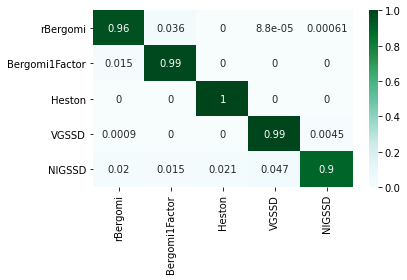

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = model_cat.predict_classes(X_test)

cm = confusion_matrix(yy_best,y_pred,normalize='true')
df_cm = pd.DataFrame(cm,model_name,model_name)
sns_plot = sns.heatmap(df_cm,annot=True,cmap=plt.cm.BuGn)

sns_plot.figure.tight_layout()

sns_fig = sns_plot.get_figure()
sns_fig.savefig('TestImages/cm_BestPred.png', dpi=300)

In [21]:
yy_best_eps_0 = to_categorical(yy_best_eps,num_classes = num_models)

accr_2 = model_cat.evaluate(X_test_eps, yy_best_eps_0)

2623/2623 [==============================] - 5s 2ms/step - loss: 0.3146 - acc: 0.9569


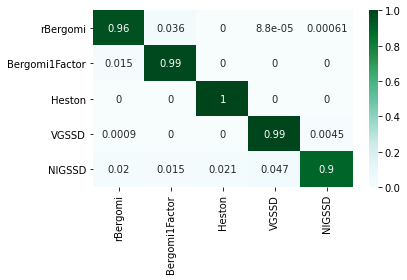

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = model_cat.predict_classes(X_test_eps)

cm = confusion_matrix(yy_best_eps,y_pred,normalize='true')
df_cm = pd.DataFrame(cm,model_name,model_name)
sns_plot = sns.heatmap(df_cm,annot=True,cmap=plt.cm.BuGn)

sns_plot.figure.tight_layout()

sns_fig = sns_plot.get_figure()
sns_fig.savefig('TestImages/cm_BestEps.png', dpi=300)

In [23]:
yy_best_eps_rand_0 = to_categorical(yy_best_eps_rand,num_classes = num_models)

accr_2 = model_cat.evaluate(X_test_eps_rand, yy_best_eps_rand_0)

2623/2623 [==============================] - 4s 2ms/step - loss: 0.3298 - acc: 0.9549


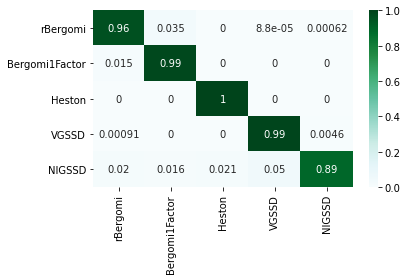

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = model_cat.predict_classes(X_test_eps_rand)

cm = confusion_matrix(yy_best_eps_rand,y_pred,normalize='true')
df_cm = pd.DataFrame(cm,model_name,model_name)
sns_plot = sns.heatmap(df_cm,annot=True,cmap=plt.cm.BuGn)

sns_plot.figure.tight_layout()

sns_fig = sns_plot.get_figure()
sns_fig.savefig('TestImages/cm_BestRand.png', dpi=300)

In [25]:
yy_best_eps_fail_0 = to_categorical(yy_best_eps_fail,num_classes = num_models)

accr_2 = model_cat.evaluate(X_test_eps_fail, yy_best_eps_fail_0)

2623/2623 [==============================] - 4s 2ms/step - loss: 11.0619 - acc: 0.4012


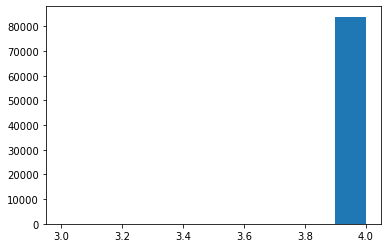

In [28]:
hist1 = plt.hist(yy_best_eps_fail)

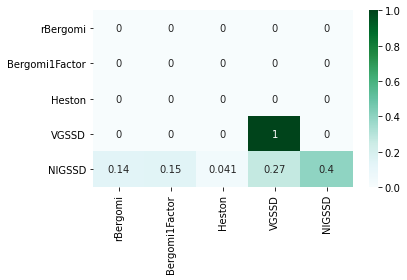

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = model_cat.predict_classes(X_test_eps_fail)

cm = confusion_matrix(yy_best_eps_fail,y_pred,normalize='true')
df_cm = pd.DataFrame(cm,model_name,model_name)
sns_plot = sns.heatmap(df_cm,annot=True,cmap=plt.cm.BuGn)

sns_plot.figure.tight_layout()

sns_fig = sns_plot.get_figure()
sns_fig.savefig('TestImages/cm_BestFail.png', dpi=300)